<img src="static/img/rosslog.png" align="left">  

# Rossmann Stores Predictions

This notebook covers basics of data cleaning, EDA, feature engineering, and data modelling. For more in-deph data analysis, please consider Kaggle Kernels: https://www.kaggle.com/c/rossmann-store-sales/kernels

**IMPORTANT: Make sure you do not skip any cells. In that case you risk not being able to accomplish given tasks.** 


## Rossmann Data Cleaning 

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. In this first part of the notebook we will walk you through basic steps that need to be done before start with baseline modelling.

### Load libraries and data

In [452]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
from pandas import DataFrame
from pandas import Grouper

# Matplotlib for visualization
from matplotlib import pyplot as plt

# Display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Show all columns
pd.set_option('display.max_columns', None)

In [453]:
# Load data from CSV
train_dataset = pd.read_csv("static/data/train.csv")
stores = pd.read_csv("static/data/store.csv")

train_dataset.head()

/Users/loi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


The train data set contains sales by day for each store with the following columns:

- Store - a unique id number
- DayOfWeek/Date - the day of the week (1-7) and date (YYYY-MM-DD) for a sales data point
- Sales - the sales for a given day
- Customers - the number of customers on a given day. This column is highly correlated with sales and is not present in the test set.
- Open - Values: 0 = closed, 1 = open
- Promo - indicates whether a store was running a sales promotion that day
- StateHoliday - Values: a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if a store was affected by the closure of public schools on that day

In [454]:
train_dataset['Month'] = pd.DatetimeIndex(train_dataset['Date']).month
train_dataset.sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month
820077,223,3,2013-06-26,5951,707,1,0,0,0,6
481213,319,6,2014-04-26,5446,586,1,0,0,0,4
439772,133,1,2014-06-02,10205,1054,1,1,0,0,6


###### Question 1

In [455]:
# YOUR CODE GOES HERE
# Print first five rows of the "stores" dataset

stores.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


The stores data set contains additional columns about each store that does not vary by day:

- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes the level of products available: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor
- CompetitionOpenSince[Month/Year] - month/year when the nearest competitor was opened
- Promo2 - indicator for a recurring promotion: 0 = store not participating, 1 = participating
- Promo2Since[Week/Year] - calendar week/year when the store started participating in Promo2
- PromoInterval - describes the intervals when Promo2 is started. E.g. "Feb,May,Aug,Nov" means each round starts in those months of any given year for that store

###### Question 2

In [456]:
# YOUR CODE GOES HERE
# Chech out the shape of the datasets. 
# We have a lot of data observations to play around.

train_dataset.shape

(1017209, 10)

In [457]:
stores.shape

(1115, 10)

Take a look and understand different data types.

In [458]:
# Column datatypes
print(train_dataset.dtypes,'\n')
print(stores.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
Month             int64
dtype: object 

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


### Drop unwanted observations

Our goal during the data cleaning phase is to fix any problems with the provided data sets, such as:

- Fix inconsistent data
- Replace missing data with reasonable values
- Remove Data that cannot be fixed
- Convert categorical variables to numeric values
- Check for outlying values, and correct them if necessary

We needed to fix these types of problems so that our prediction models could be fit as accurately as possible.

In [459]:
# Check for duplicates
train_dataset = train_dataset.drop_duplicates()
stores = stores.drop_duplicates()

# Print shape after removing duplicates
train_dataset.shape, stores.shape

((1017209, 10), (1115, 10))

There were no duplicates. Now, let us check closed stores, stores with no customers, and stores where sales values equals zero.

In [460]:
# Drop closed observation
train_dataset1 = train_dataset[train_dataset.Open != 0]
train_dataset1.shape

(844392, 10)

###### Question 3

In [461]:
# YOUR CODE GOES HERE
# Print the number of stores where Customers=0

train_dataset[train_dataset.Customers == 0].shape

(172869, 10)

In [462]:
train_dataset[train_dataset.Customers == 0].sort_values(by=['Store']).head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month
604660,1,7,2014-01-05,0,0,0,0,0,1,1
114845,1,7,2015-04-19,0,0,0,0,0,0,4
192895,1,7,2015-02-08,0,0,0,0,0,0,2
885640,1,7,2013-04-28,0,0,0,0,0,0,4
1016095,1,2,2013-01-01,0,0,0,0,a,1,1


###### Question 4

In [463]:
# YOUR CODE GOES HERE
# Print the number of stores where Sales=0

train_dataset[train_dataset.Sales == 0].shape

(172871, 10)

In [464]:
train_dataset[train_dataset.Sales == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month
291,292,5,2015-07-31,0,0,0,1,0,1,7
875,876,5,2015-07-31,0,0,0,1,0,1,7
1406,292,4,2015-07-30,0,0,0,1,0,1,7
1990,876,4,2015-07-30,0,0,0,1,0,1,7
2521,292,3,2015-07-29,0,0,0,1,0,1,7
...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1


After checking the data, we decide to drop Sales == 0 observations:

In [465]:
train_dataset = train_dataset[train_dataset.Sales != 0]

In [466]:
train_dataset.shape

(844338, 10)

### Feature engineering

We are going to create new feature called "AvgPurchasing" we will use in the second section of this notebook. Than, we summarize numerical features to understand our data better.

In [467]:
train_dataset['AvgPurchasing'] = train_dataset.Sales / train_dataset.Customers

In [468]:
# Summarize numerical features
train_dataset.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Month,AvgPurchasing
count,844338.000000,844338.000000,844338.000000,844338.000000,844338.0,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,6955.959134,762.777166,1.0,0.446356,0.193578,5.845774,9.493641
std,321.730861,1.723712,3103.815515,401.194153,0.0,0.497114,0.395102,3.323959,2.197448
min,1.000000,1.000000,46.000000,8.000000,1.0,0.000000,0.000000,1.000000,2.749075
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,3.000000,7.895571
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,6.000000,9.250000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,8.000000,10.899729
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,12.000000,64.957854


In [469]:
# Promo2Since[Year/Week] 
# Describes the year and calendar week 
# when the store started participating in Promo2

stores.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### Missing values of numerical features

Let us check for missing values and fill in any add indicator variable for missing data

In [470]:
print(train_dataset.select_dtypes(exclude=['object']).isnull().sum(),'\n')
print(stores.select_dtypes(exclude=['object']).isnull().sum())

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
SchoolHoliday    0
Month            0
AvgPurchasing    0
dtype: int64 

Store                          0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
dtype: int64


In [471]:
# For the competion data, check the 3 missing CompetitionDistance
stores[stores['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [472]:
# Fill and flag the missing numeric data

stores.CompetitionOpenSinceMonth.fillna(0, inplace=True)
stores.CompetitionOpenSinceYear.fillna(0, inplace=True)
stores.CompetitionDistance.fillna(0, inplace=True)

# Indicator variable for missing numeric data

stores['CompetitionOpenSinceMonth_missing'] = stores.CompetitionOpenSinceMonth.isnull().astype(int)
stores['CompetitionOpenSinceYear_missing'] = stores.CompetitionOpenSinceYear.isnull().astype(int)
stores['CompetitionDistance_missing'] = stores.CompetitionDistance.isnull().astype(int)

# Just fill the nan with 0 

stores.Promo2SinceWeek.fillna(0, inplace=True)
stores.Promo2SinceYear.fillna(0, inplace=True)
stores.PromoInterval.fillna(0, inplace=True)

In [473]:
stores.isnull().sum()

Store                                0
StoreType                            0
Assortment                           0
CompetitionDistance                  0
CompetitionOpenSinceMonth            0
CompetitionOpenSinceYear             0
Promo2                               0
Promo2SinceWeek                      0
Promo2SinceYear                      0
PromoInterval                        0
CompetitionOpenSinceMonth_missing    0
CompetitionOpenSinceYear_missing     0
CompetitionDistance_missing          0
dtype: int64

### Categorical features cleaning

Notice that we have two zero values: one integer and one string. Let us fix this and have one string zero value for all StateHoliday representations.

In [474]:
# Display unique values of 'StateHoliday'
train_dataset.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

###### Question 5

In [475]:
# YOUR CODE
# Your result shoud look like this: 
### array(['0', 'a', 'b', 'c'], dtype=object)

#train_dataset['StateHoliday'].replace(0,'0')
#train_dataset.StateHoliday.unique()
#train_dataset[train_dataset.StateHoliday == 0]['StateHoliday']

train_dataset['StateHoliday'] = train_dataset['StateHoliday'].astype('str')
train_dataset.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

Check missing values for categorical variables

In [476]:
# Display number of missing values by categorical feature
print(train_dataset.select_dtypes(include=['object']).isnull().sum(), '\n')
print(stores.select_dtypes(include=['object']).isnull().sum())

Date            0
StateHoliday    0
dtype: int64 

StoreType        0
Assortment       0
PromoInterval    0
dtype: int64


### Joining the "Train" and "Store" tables 

Before joining our tables, we need to set both of our table indexes. Let us set the Store values as our new table indexes.

###### Question 6

In [477]:
# YOUR CODE
# Set index in train_dataset to corespond to the train_dataset['Store'] values
# Set index in stores to corespond to the stores['Store'] values
# Drop Store column in train_dataset

try:
    train_dataset = train_dataset.set_index('Store')
except:
    pass
train_dataset.sample(1)

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,AvgPurchasing
Store,,,,,,,,,,
961,4,2013-11-07,6458,651,1,1,0,0,11,9.920123


In [478]:
try:
    stores = stores.set_index('Store')
except:
    pass
stores.sample(1)

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
Store,,,,,,,,,,,,
23,d,a,4060.0,8.0,2005.0,0,0.0,0.0,0,0,0,0


In [479]:
df_combined = train_dataset.join(stores)
df_combined = df_combined.reset_index(drop=False)
df_combined.sample(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,AvgPurchasing,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
370707,489,6,2013-02-16,2703,269,1,0,0,0,2,10.048327,a,a,14960.0,11.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",0,0,0


### Convert store type and assortiman from char to int

StateHoliday, StoreType, and Assortment, needs to be transformed into one-hot-encoding after all the cleaning and feature engineering. Let us explore each of this features unique values and replace them with int values. For example:

1. StoreType ['a', 'b', 'c', 'd'] needs to be converted into [1, 2, 3, 4]
2. Assortment ['a', 'b', 'c'] needs to be converted into [1, 2, 3]
3. StateHoliday ['0', 'a', 'b', 'c'] needs to be converted into [0 ,1, 2, 3]

In [480]:
df_combined.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [481]:
df_combined.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [482]:
df_combined.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [483]:
df_combined.SchoolHoliday.unique()

array([1, 0])

###### Question 7

In [484]:
# YOUR CODE
# Transforme into one-hot-encoding 
# Result should look like: 

#### StoreType ['a', 'b', 'c', 'd'] needs to be converted into [1, 2, 3, 4]
#### Assortment ['a', 'b', 'c'] needs to be converted into [1, 2, 3]
#### StateHoliday ['0', 'a', 'b', 'c'] needs to be converted into [0 ,1, 2, 3]

df_combined = df_combined.replace({'StoreType': {'a': 1, 'b': 2, 'c': 3, 'd':4}})
df_combined = df_combined.replace({'Assortment': {'a': 1, 'b': 2, 'c': 3}})
df_combined = df_combined.replace({'StateHoliday': {'0': 0, 'a': 1, 'b': 2, 'c':3}})
df_combined.sample(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,AvgPurchasing,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
405740,536,2,2014-12-02,13184,1227,1,1,0,0,12,10.744906,1,3,4700.0,9.0,2002.0,1,31.0,2013.0,"Feb,May,Aug,Nov",0,0,0


In [485]:
# Check out your previous code
try:
    print("StoreType: ", np.sort(df_combined.StoreType.unique()))
    print("Assortment: ", np.sort(df_combined.Assortment.unique()))
    print("StateHoliday: ", np.sort(df_combined.StateHoliday.unique()))
except:
    pass
df_combined.sample(1)

StoreType:  [1 2 3 4]
Assortment:  [1 2 3]
StateHoliday:  [0 1 2 3]


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,AvgPurchasing,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
585240,774,4,2014-08-07,5417,669,1,1,0,1,8,8.09716,1,3,640.0,9.0,2013.0,0,0.0,0.0,0,0,0,0


## EDA

To determine what type of models and predictors might work best for predicting sales, we studied which factors are causing the most variance in sales.

#### Variations based on Store Attributes

One of the biggest sources of variance in sales is based on the store number. In the graph below we show the average sales for the first ten stores in the data set. We can see that the average sales are quite different for each store and that there is no linear pattern. We do see stores with similar sales levels, suggesting the stores may fall into groups.

The scatterplot below that shows the average sales for all the stores. We can again see that some stores have similar levels of sales, so it's likely we can group stores together when making sales predictions, which is something for which tree models are well suited.

Each store number is effectively a category with its own particular sales level. When predicting future sales, we would like a single model that can make predictions for each store rather than having to fit a separate model for each store.

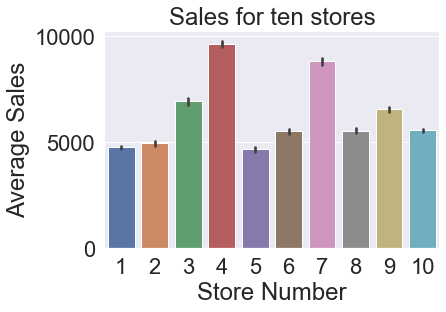

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


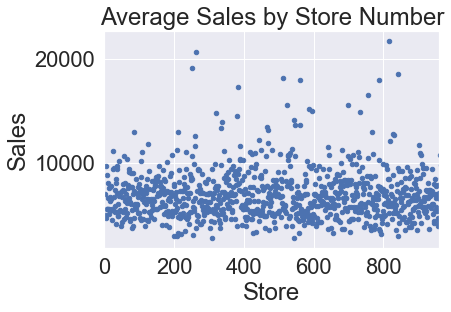

In [486]:
df_subset = df_combined[(df_combined['Store'] < 11)]
sns.set(font_scale=2)

# Plot store sales for stores 1 to 10
fig, ax = plt.subplots(1,1)

p3 = sns.barplot(x='Store', y='Sales', data=df_subset, ax=ax)
ax.set(xlabel='Store Number')
ax.set_ylabel('Average Sales')
ax.set_title('Sales for ten stores')

plt.show()

# Create a plot of average sales per store id
avg_sales_per_store = df_combined[['Sales', 'Store']].groupby('Store').mean()
avg_sales_per_store.reset_index().plot(kind='scatter', x='Store', y='Sales')
plt.xlim(0,960)
plt.title("Average Sales by Store Number")
plt.show()

The data set has categorical variables for different store types and the assortment of products for sale at each store. We see that these categories are a source of variance in sales.

#### Impact of Number of Customers

After exploration of the train and test sets, we ascertained that only the training data contains the number of Customers feature. The visualization below shows the positive correlation between the number of customers and sales (and also outliers). This feature is highly correlated with sales, but it’s not available until after the sales occur (i.e. it’s not in the test set). But exploring this feature helps make a case for including a proxy for the Customers feature in our final predictors (see the Feature Engineering section).

We also see that there’s added information with the behavior of customers per StoreType. We see that StoreType d (shown in green) that projects to the upper left quadrant. This means that for the same level of Sales, StoreType d requires fewer customers than StoreType b (blue). There’s less clarity of StoreType impact in the middle of the cone shaped scatter, but we can certainly see the impact of Customers and Sales conditional on the StoreType mostly in the outer regions of the visualization. Thus StoreType is a relevant feature, but as a function of Customers, as we can see that around 2000 to 3000 Customers there’s a break in the cluster pattern of the middle section of the cone. Therefore, further substantiation for us to include a proxy of the Customers feature in the model.

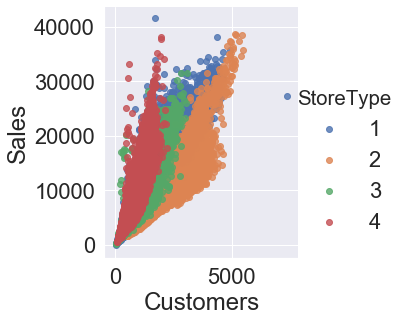

In [487]:
sns.lmplot(x='Customers', y='Sales', data=df_combined, hue='StoreType',fit_reg=False)

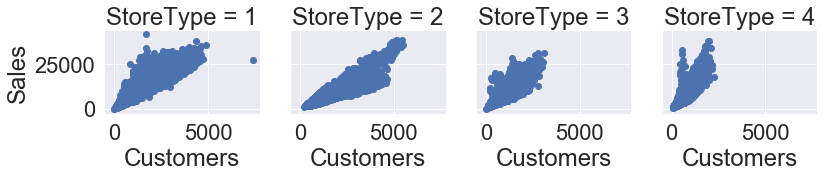

In [488]:
g = sns.FacetGrid(df_combined, col="StoreType")
g.map(plt.scatter, "Customers", "Sales")

In [489]:
%%script false --no-raise-error
sns.pairplot(train_dataset.sample(1000))
#train_dataset.sample(1000)

## Make Dummy Variables

In [490]:
df_combined.sample(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,AvgPurchasing,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
496530,657,5,2015-07-17,4997,647,1,1,0,1,7,7.723338,3,3,80.0,1.0,2006.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",0,0,0


In [491]:
try:
    df_combined_temp = pd.get_dummies(df_combined, columns=['StoreType'])
    df_combined_temp = pd.get_dummies(df_combined_temp, columns=['Assortment'])
    df_combined_temp = pd.get_dummies(df_combined_temp, columns=['StateHoliday'])
    df_combined_temp = df_combined_temp.drop(['Open'],axis=1)
except:
    pass
df_combined_temp.sample(1)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,Month,AvgPurchasing,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
758891,1003,3,2014-11-26,7808,809,1,0,11,9.651422,170.0,7.0,2013.0,1,27.0,2013.0,"Jan,Apr,Jul,Oct",0,0,0,1,0,0,0,1,0,0,1,0,0,0


In [492]:
df_combined_clean = df_combined_temp.copy()
df_combined_clean = df_combined_clean.reindex(sorted(df_combined_clean.columns), axis=1)
df_combined_clean.sample(1)

,Assortment_1,Assortment_2,Assortment_3,AvgPurchasing,CompetitionDistance,CompetitionDistance_missing,CompetitionOpenSinceMonth,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear,CompetitionOpenSinceYear_missing,Customers,Date,DayOfWeek,Month,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Store,StoreType_1,StoreType_2,StoreType_3,StoreType_4
611554,1,0,0,10.323162,12770.0,0,10.0,0,2000.0,0,721,2014-09-08,1,9,0,0,0.0,0.0,0,7443,0,1,0,0,0,809,1,0,0,0


## Rossmann Data Modeling

Due to the regressive predictive nature of The Rossmann Project, we decided to approach our model methodology with a Linear Regression base model with feature selection. Note: you can also consider Ridge regression to evaluate the effects of regularization on the predictive performance. 

*Note: The time dimension has a tremendous impact in this project. The Kaggle competition consisted in predicted the next 6 weeks (or 42 days), our splitting lead to have a testing set very large of over 900 days, explaining the fast degradation of the explained variance. These issues are the same the world of finance and economics are facing. For example the usage of an AR(n) to predict future outcomes quickly converge to a stationary states. In a real world, one would adjust the model based on the observed error. This is the spirit of tools such as the 'Kalman Filter' that are usually implemented in these domains.* 

*One other potential approach would consist in implementing more complicated model that naturally combine time series and decision tree, such as ART (Autoregressive Trees). The proposed method are outside of the scope of this course and thus we will focus on some other tehniques here.*

### Linear Regression

For our first baseline model, we decided to use linear regression. We used one hot encoding to convert categorical values into indicator columns. The store number is effectively a category with over 1000 different categories. We know that sales is not linear with the arbitrary numbers assigned to stores, so if this were our final model, it might have been reasonable to fit a separate regression model for each store. But since this is a baseline model, we treated the high dimension categories as if they were numeric values.

In the next section we will explore how different features affect overall score. You will be challenged to spot the differences and explain what given results mean.

#### Load libraries

In [493]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Let us drop some temporal features given that we are not performing time-series analysis.

In [494]:
#drop PromoInterval (includes Mar,Jun,Sept,Dec)
#drop Date -> no time-series prediction

no_Promo_Date = df_combined_clean.drop(['PromoInterval', 'Date', 'Store'], axis=1)
# create tagret (Sales) variable 
target = no_Promo_Date['Sales']
no_Promo_Date.sample(3)

,Assortment_1,Assortment_2,Assortment_3,AvgPurchasing,CompetitionDistance,CompetitionDistance_missing,CompetitionOpenSinceMonth,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear,CompetitionOpenSinceYear_missing,Customers,DayOfWeek,Month,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales,SchoolHoliday,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
717028,0,1,0,3.863350,1430.0,0,0.0,0,0.0,0,1427,6,5,0,0,0.0,0.0,5513,0,1,0,0,0,0,1,0,0
163352,0,0,1,7.274123,640.0,0,0.0,0,0.0,0,456,6,3,0,1,9.0,2011.0,3317,0,1,0,0,0,1,0,0,0
791704,0,0,1,13.159544,29070.0,0,4.0,0,2005.0,0,702,4,11,1,0,0.0,0.0,9238,0,1,0,0,0,0,0,0,1


#### Linear Regression: *ver. 1*

R2 score: 0.82


Text(0.5, 1.0, 'Sales Predicted(blue) vs Actual(red) LR Ver1')

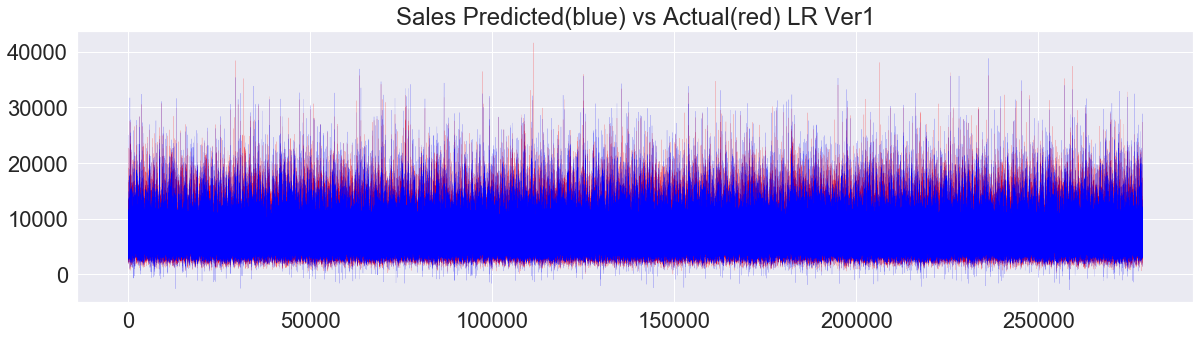

In [495]:
# Drop Sales and AvgPurchasing, but leave Customers
drop_sales_avg_df = no_Promo_Date.drop(['Sales', 'AvgPurchasing'], axis=1)

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(drop_sales_avg_df, target, test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)
plt.title("Sales Predicted(blue) vs Actual(red) LR Ver1")

In short, explain what the above plot and its specific trend.

###### Question 8

** Your answer: **







*The plot above shows that the predictions(blue) are generally less than the actual(red).  Most of the predictions are fairly uniform in the range of 10000 to 20000.  Actual sales have more variation and can range from 10000 to 30000.*

*The R2 value is about 0.8 which is great.*

*However, customers is included as a feature, which we do not have when doing a real test prediction.  So, this model may not be useful.*

*The plots below provides more info on the regression model.*

In [496]:
# Redo regression with statsmodel to get summary
import statsmodels.api as sm
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 1.409e+05
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:48:34   Log-Likelihood:            -4.8576e+06
No. Observations:              565706   AIC:                         9.715e+06
Df Residuals:                  565686   BIC:                         9.716e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

*P>|t| is 0.000 for all features, which indicates they are all important*

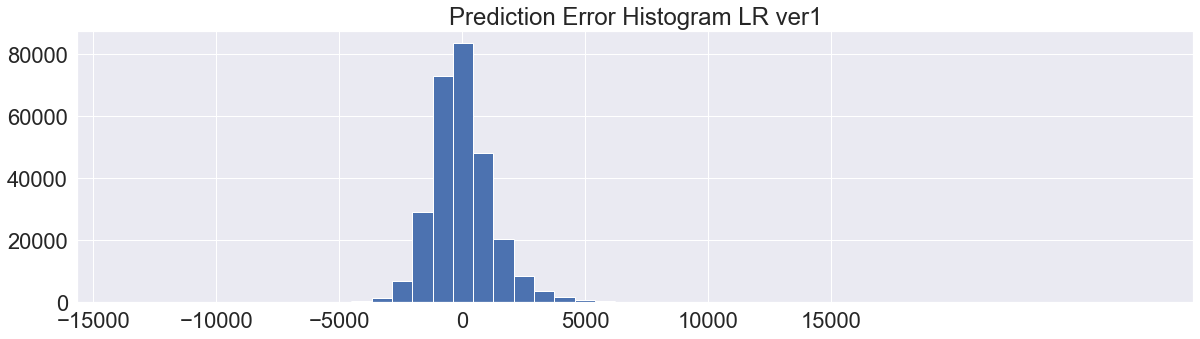

In [497]:
plt.figure(figsize=(20, 5))
plt.xticks(range(-20000,20000,5000))
plt.title("Prediction Error Histogram LR ver1")
_ = plt.hist(y_test.values - y_pred,bins=50)

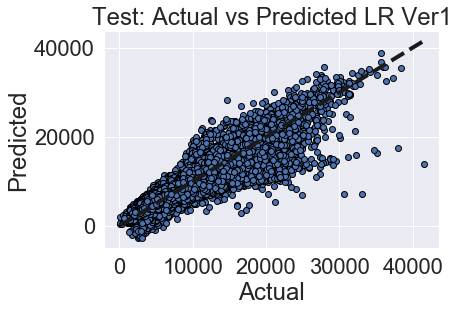

In [498]:
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Test: Actual vs Predicted LR Ver1")
plt.show()

#### Linear Regression: *ver. 2*

###### Question 9

R2 score: 0.94


Text(0.5, 1.0, 'Sales Predicted vs Actual LR Ver2')

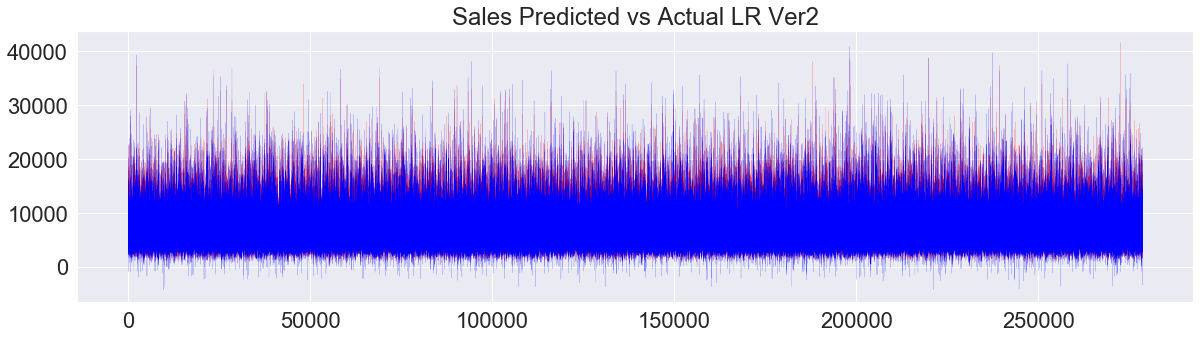

In [499]:
# YOUR CODE
# Drop Sales, but leave Customers and AvgPurchasing
# Elaborate about given R2 score

drop_sales_df = no_Promo_Date.drop(['Sales'], axis=1)

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(drop_sales_df, target, test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()
regr2 = regr

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)
plt.title("Sales Predicted vs Actual LR Ver2")

** Your answer: **

*The plots above shows the most of the prediction error range from -2500 to 2500, with some ranging in -10000 to 10000.*
*The R2 value is above 0.9, which is very good.  This Version 2 model is better than Verson 1.  The predictions are closely packed around the black perfect prediction line.*

*However, customers is included as a feature, which we do not have when doing a real test prediction.  So, this model may not be useful.*

In [500]:
# Redo regression with statsmodel to get summary
import statsmodels.api as sm
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 4.495e+05
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:48:41   Log-Likelihood:            -4.5506e+06
No. Observations:              565706   AIC:                         9.101e+06
Df Residuals:                  565685   BIC:                         9.102e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

*P>|t| is 0.000 for all features, which indicates they are all important*

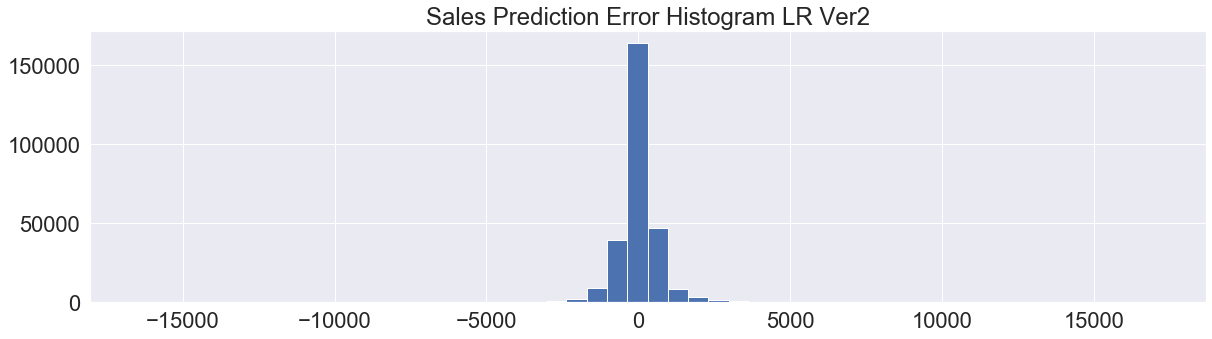

In [501]:
plt.figure(figsize=(20, 5))
plt.xticks(range(-20000,20000,5000))
plt.title("Sales Prediction Error Histogram LR Ver2")
_ = plt.hist(y_test.values - y_pred,bins=50)

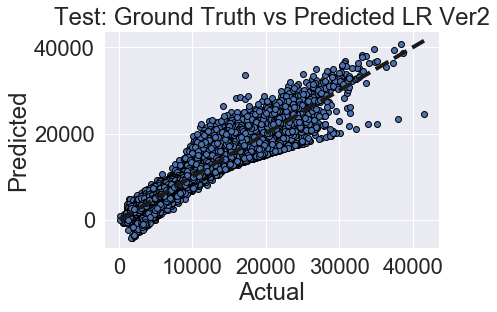

In [502]:
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Test: Ground Truth vs Predicted LR Ver2")
plt.show()

#### Linear Regression: *ver. 3*

R2 score: 0.25


Text(0.5, 1.0, 'Sales Predicted vs Actual LR Ver3')

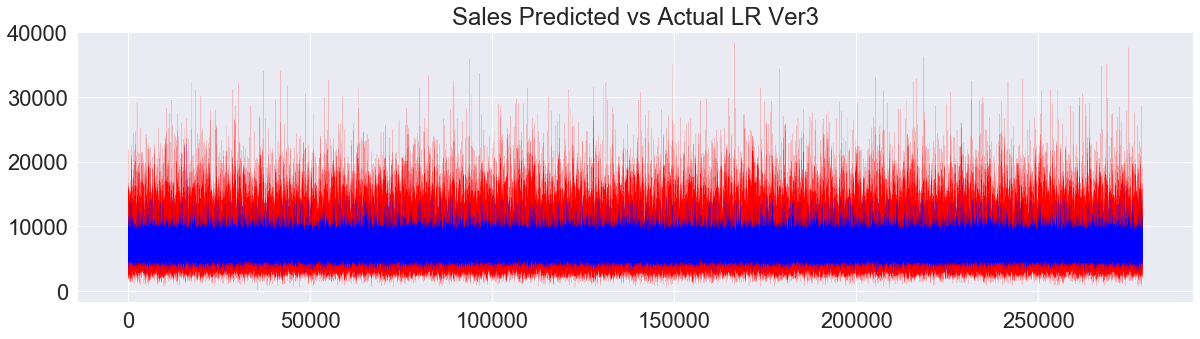

In [503]:
# Drop Sales and Customers
drop_sales_avg_df = no_Promo_Date.drop(['Sales', 'Customers'], axis=1)

# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(drop_sales_avg_df, target, test_size=0.33)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(20, 5))

plt.plot(y_test.values, color='red', linewidth=0.1)
plt.plot(y_pred, color='blue', linewidth=0.1)
plt.title("Sales Predicted vs Actual LR Ver3")

###### Question 10

** Your answer: **

The errors are more widely distributed over -5000 and 5000, with some at 5000 to 10000.  The R2 score is 0.2, which is very low.  This is the worse model out of all three.

Out of the 3 models, only this one has removed customers as a feature, which we do not have when doing a real test prediction.  So, it would make more sense to use this feature set to make real test predictions.

In [504]:
# Redo regression with statsmodel to get summary
import statsmodels.api as sm
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     9870.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:48:49   Log-Likelihood:            -5.2702e+06
No. Observations:              565706   AIC:                         1.054e+07
Df Residuals:                  565686   BIC:                         1.054e+07
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

*P>|t| is 0.000 for most features, which indicates they are important.*

*This value is high for StateHoliday, so this feature may not be important*

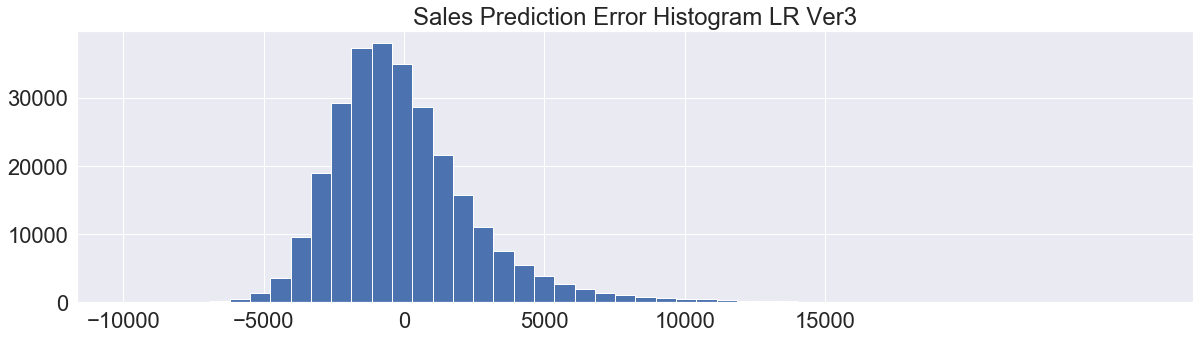

In [505]:
plt.figure(figsize=(20, 5))
plt.xticks(range(-20000,20000,5000))
plt.title("Sales Prediction Error Histogram LR Ver3")
_ = plt.hist(y_test.values - y_pred,bins=50)

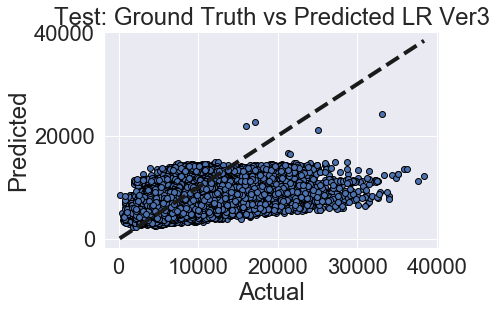

In [506]:
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Test: Ground Truth vs Predicted LR Ver3")
plt.show()

*All the predictions seems to be clusters between 0 and 20000, regardless of the actual values, which range form 0 to 40000*

### Tree Based Models

It has been well established that bagging and other resampling techniques can be used to reduce the variance in model predictions. As several replicates of the original data set are created using random selection with replacement, at every step, each derivative data set is then used to construct a new model and the models are gathered together into an ensemble. To make a prediction, all of the models in the ensemble are polled and their results are averaged in the case of regression, which is our specific approach.

As well, it has been well established that a powerful modeling algorithm that makes good use of bagging is Random Forests, which works by training numerous decision trees each based on a different resampling of the original training data. The random forest algorithm improves on bagging by training each tree on a random sample of the available features, to prevent each tree from choosing the same predictors.

In Random Forests the bias of the full model is equivalent to the bias of a single decision tree, which itself has high variance. By creating many of these trees, a forest, and then averaging them, the variance of the final model can be greatly reduced over that of a single tree. In practice the only limitation we encountered on the size of the forest is computing time, as an infinite number of trees could be trained without ever increasing bias and with a continual - if asymptotically declining - decrease in the variance.

It is for the aforementioned that we considered Random Forests as a Baseline Ensemble and its constituent, the Decision Tree Regressor as a baseline model as well.

### Decision Trees

Decision trees were implemented as to evaluate the base consituent of the Random Forest ensemble. As per our research on previous models, Random Forest is a very good performance candidate for a baseline ensemble model for Rossmann.

Decision Trees are also evaluated as a non-parametric baseline model, which enriches the comparative analysis of the Linear Regression Models.

For fitting the decision tree model, we do not need to create dummy variables for categorical columns, since trees are able to make use of the factorized category values we created during data cleaning.

### Random Forest

Next we considered Random Forest models. 

In [507]:
df_combined_clean.sample(1)

,Assortment_1,Assortment_2,Assortment_3,AvgPurchasing,CompetitionDistance,CompetitionDistance_missing,CompetitionOpenSinceMonth,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear,CompetitionOpenSinceYear_missing,Customers,Date,DayOfWeek,Month,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,SchoolHoliday,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Store,StoreType_1,StoreType_2,StoreType_3,StoreType_4
560632,0,0,1,9.971198,4380.0,0,0.0,0,0.0,0,868,2015-02-20,5,2,1,0,0.0,0.0,0,8655,0,1,0,0,0,742,0,0,0,1


In [508]:
# Load libraries
from sklearn.ensemble import RandomForestRegressor
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Clean your data
target = df_combined_clean['Sales']
clean_df = df_combined_clean.drop(['Sales', 'Customers', 'AvgPurchasing', 'PromoInterval', 'Date', 'Store'], axis=1)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(clean_df, target, test_size=0.33)

# use most recent data as test data
# target = clean_df['Sales']
# clean_df = df_combined.sort_values('Date').drop(['Sales', 'Customers', 'AvgPurchasing', 'PromoInterval', 'Date'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(clean_df, target, test_size=0.33, shuffle=False, random_state=None)

In [509]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

#### Parameter Tuning via CV GridSearch

The paramters to be tuned are:

- max_depth
- n_estimartors
- max_features
- random_state

IMPORTANT: This might take a while!!!

In [510]:
#%%script false --no-raise-error

# tuning n_estimators
parameters = {'max_depth': [8, 9, 10], # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              'n_estimators': [10, 20, 30], # [ 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
              'max_features': [None], # [None, 'auto', 'sqrt', 'log2']
              'random_state': [10, 44], # [None, 10, 44, 100]
}
           
rf = RandomForestRegressor(max_depth=1, random_state=10)
optmized_rf_trees = cv_optimize(rf, parameters, X_train_rf, y_train_rf, n_jobs=-1, n_folds=5)

KeyboardInterrupt: 

In [511]:
#%%script false --no-raise-error

print ('\nThe tuned parameters in the RF w/ customers, via CV grid search are:\n')
print ('Max tree depth: {}\nNumber of Estimators {}\nMax Features: {}\nRandom State {}'.\
                                                                     format(optmized_rf_trees.max_depth,
                                                                     optmized_rf_trees.n_estimators,
                                                                     optmized_rf_trees.max_features,
                                                                     optmized_rf_trees.random_state) )


The tuned parameters in the RF w/ customers, via CV grid search are:



NameError: name 'optmized_rf_trees' is not defined

The tuned parameters in the RF w/ customers, via CV grid search are:

Max tree depth: 10
Number of Estimators 30
Max Features: None
Random State 10

###### Question 11

In [ ]:
# YOUR CODE
# Run RandomForestRegressor with best params
# Elaborate about given R2 score

clf = RandomForestRegressor(n_estimators=10, max_depth=10, max_features=None, random_state=10, verbose=1)
clf.fit(X_train_rf, y_train_rf)
y_pred_rf = clf.predict(X_test_rf)

In [ ]:
clf.score(X_train_rf, y_train_rf)

In [ ]:
clf.score(X_test_rf, y_test_rf)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(y_test_rf, y_pred_rf, edgecolors=(0, 0, 0))
ax.plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Test: Ground Truth vs Predicted")
plt.show()

*The model is not very accurate, the R2 score is 0.52*

*The predicted vs actual plot indicates some correlation between predicted and actual, with a large spread around the perfect prediction dash line*

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(y_test_rf, (y_pred_rf-y_test_rf)/y_test_rf, edgecolors=(0, 0, 0))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Test: Ground Truth vs Predicted Error(Percentage)")
plt.xlim([100, 40000]) 
plt.ylim([-2, 2]) 
plt.show()

*Percentage wise, the error appears about 50% off across actual sales of 10000 to 40000*

*The error exponentially increases for lower actual sales.*

In [ ]:
plt.figure(figsize=(20, 5))
#plt.xticks(range(-2000,8000,500))
plt.title("Sales Prediction Error Histogram")
_ = plt.hist(y_test_rf - y_pred_rf, bins = 100)

###### Question 12

#### What is the best model? ** Your answer: **

*The random forest model is best, R2=0.52.  The LR3 model R2=0.25.  The LR1 and LR2 model cannot be used because it includes customers as a feature, which is not given in the test data.*

## Export models 

In our final step, we will choose the best model and explore some important prediction elements. Our app accepts features and gives predictions based on users inputs. Let us see what kind of data input is neccessarry (this is important for you to setup the proper input on the Flask side). 

For example, take one simple observation (we are using first data row):

In [512]:
# Print first row
X_test_rf.iloc[0]

Assortment_1                            0.0
Assortment_2                            0.0
Assortment_3                            1.0
CompetitionDistance                  8090.0
CompetitionDistance_missing             0.0
CompetitionOpenSinceMonth               0.0
CompetitionOpenSinceMonth_missing       0.0
CompetitionOpenSinceYear                0.0
CompetitionOpenSinceYear_missing        0.0
DayOfWeek                               6.0
Month                                   7.0
Promo                                   0.0
Promo2                                  0.0
Promo2SinceWeek                         0.0
Promo2SinceYear                         0.0
SchoolHoliday                           0.0
StateHoliday_0                          1.0
StateHoliday_1                          0.0
StateHoliday_2                          0.0
StateHoliday_3                          0.0
StoreType_1                             1.0
StoreType_2                             0.0
StoreType_3                     

In [513]:
X_test_rf.sample(1)

,Assortment_1,Assortment_2,Assortment_3,CompetitionDistance,CompetitionDistance_missing,CompetitionOpenSinceMonth,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear,CompetitionOpenSinceYear_missing,DayOfWeek,Month,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,SchoolHoliday,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
191746,0,0,1,4630.0,0,3.0,0,2011.0,0,4,8,1,1,35.0,2011.0,1,1,0,0,0,0,0,1,0


Predict based on your first row:

In [514]:
# Test for your app
clf.predict(np.array(X_test_rf.iloc[0].values.reshape(1, -1)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([6208.08016269])

In [515]:
y_test_rf.iloc[0]

5171

In [516]:
np.array(X_test_rf.iloc[0].values.reshape(1, -1))

array([[0.00e+00, 0.00e+00, 1.00e+00, 8.09e+03, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 6.00e+00, 7.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]])

Similar to the above line:

In [517]:
clf.predict(np.array([[1.000e+00, 0.000e+00, 0.000e+00, 1.010e+03, 0.000e+00, 9.000e+00,
        0.000e+00, 2.012e+03, 0.000e+00, 3.000e+00, 6.000e+00, 0.000e+00,
        1.000e+00, 1.800e+01, 2.011e+03, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00]]).reshape(1, -1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([4426.30786722])

We can conclude that your input needs to be **numpy array**. Now, we can export pur model and get ready for the second part of the homework.

In [518]:
from sklearn.externals import joblib
joblib.dump(clf, 'rm.pkl')

['rm.pkl']

## Format web input for prediction

In [519]:
stores.sample(1)

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing
Store,,,,,,,,,,,,
292,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,0,0,0


In [520]:
#stores dummy joins with web user data
#use this code in app.py
stores_dummy = stores.copy()
stores_dummy = stores_dummy.replace({'StoreType': {'a': 1, 'b': 2, 'c': 3, 'd':4}})
stores_dummy = stores_dummy.replace({'Assortment': {'a': 1, 'b': 2, 'c': 3}})
stores_dummy = pd.get_dummies(stores_dummy, columns=['StoreType'])
stores_dummy = pd.get_dummies(stores_dummy, columns=['Assortment'])
stores_dummy.sample(2)

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
Store,,,,,,,,,,,,,,,,,
345,120.0,0.0,0.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct",0,0,0,1,0,0,0,1,0,0
376,160.0,8.0,2012.0,0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0


In [523]:
stores_dummy.to_csv("stores_dummy.csv")

In [528]:
stores_read = pd.read_csv("stores_dummy.csv",index_col=0)
stores_read.sample(2)

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,CompetitionDistance_missing,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
Store,,,,,,,,,,,,,,,,,
174,13090.0,0.0,0.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct",0,0,0,1,0,0,0,1,0,0
583,2640.0,11.0,2002.0,0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0


In [529]:
#make a row based on web user data
#use this code in app.py
month = 2
day = 5
promo = 0
state_holiday = 1
school_holiday = 1
store = 11
row = stores_read.iloc[[store-1]].copy()
row['Month']=month
row['DayOfWeek']=day
row['Promo']=promo
row['StateHoliday_0']=(1 if state_holiday==0 else 0)
row['StateHoliday_1']=(1 if state_holiday==1 else 0)
row['StateHoliday_2']=(1 if state_holiday==2 else 0)
row['StateHoliday_3']=(1 if state_holiday==3 else 0)
row['SchoolHoliday']=promo
row = row.reindex(sorted(row.columns), axis=1)
row = row.drop(['PromoInterval'],axis=1)
print(row.size)
print(row.iloc[0])
row.iloc[[0]]

24
Assortment_1                            0.0
Assortment_2                            0.0
Assortment_3                            1.0
CompetitionDistance                   960.0
CompetitionDistance_missing             0.0
CompetitionOpenSinceMonth              11.0
CompetitionOpenSinceMonth_missing       0.0
CompetitionOpenSinceYear             2011.0
CompetitionOpenSinceYear_missing        0.0
DayOfWeek                               5.0
Month                                   2.0
Promo                                   0.0
Promo2                                  1.0
Promo2SinceWeek                         1.0
Promo2SinceYear                      2012.0
SchoolHoliday                           0.0
StateHoliday_0                          0.0
StateHoliday_1                          1.0
StateHoliday_2                          0.0
StateHoliday_3                          0.0
StoreType_1                             1.0
StoreType_2                             0.0
StoreType_3                  

,Assortment_1,Assortment_2,Assortment_3,CompetitionDistance,CompetitionDistance_missing,CompetitionOpenSinceMonth,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear,CompetitionOpenSinceYear_missing,DayOfWeek,Month,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,SchoolHoliday,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
Store,,,,,,,,,,,,,,,,,,,,,,,,
11,0,0,1,960.0,0,11.0,0,2011.0,0,5,2,0,1,1.0,2012.0,0,0,1,0,0,1,0,0,0


In [530]:
clf.predict(row)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([5077.3775405])

In [522]:
#verify data is same format as training set
trow = X_train_rf.sample(1)
print(trow.size)
print(trow.iloc[0])
trow.iloc[[0]]

24
Assortment_1                            1.0
Assortment_2                            0.0
Assortment_3                            0.0
CompetitionDistance                   180.0
CompetitionDistance_missing             0.0
CompetitionOpenSinceMonth               3.0
CompetitionOpenSinceMonth_missing       0.0
CompetitionOpenSinceYear             2014.0
CompetitionOpenSinceYear_missing        0.0
DayOfWeek                               6.0
Month                                  12.0
Promo                                   0.0
Promo2                                  0.0
Promo2SinceWeek                         0.0
Promo2SinceYear                         0.0
SchoolHoliday                           0.0
StateHoliday_0                          1.0
StateHoliday_1                          0.0
StateHoliday_2                          0.0
StateHoliday_3                          0.0
StoreType_1                             1.0
StoreType_2                             0.0
StoreType_3                  

,Assortment_1,Assortment_2,Assortment_3,CompetitionDistance,CompetitionDistance_missing,CompetitionOpenSinceMonth,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear,CompetitionOpenSinceYear_missing,DayOfWeek,Month,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,SchoolHoliday,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
198662,1,0,0,180.0,0,3.0,0,2014.0,0,6,12,0,0,0.0,0.0,0,1,0,0,0,1,0,0,0
